# Sales Forecast And Comparative Analysis of Company Profiles

## INTRODUCTION
The Cab Industry in the United States has experienced remarkable growth in recent years, with multiple key players vying for market dominance. XYZ, a private firm, is considering making an investment in the Cab industry. As part of their Go-to-Market (G2M) strategy, XYZ aims to gain a comprehensive understanding of the market before making a final decision.

To support XYZ's investment decision, a thorough analysis of multiple data sets pertaining to two prominent cab companies was conducted. The objective was to extract actionable insights that would aid in identifying the right company for investment. This report presents the findings and recommendations based on the analysis, focusing on various aspects of customer profiles, market dynamics, and profitability.

### DataSet:
4 individual data sets were provided for the analysis. Time period of data is from 31/01/2016 to 31/12/2018.

Below are the list of datasets which are provided for the analysis:

**Cab_Data.csv** – this file includes details of transaction for 2 cab companies

**Customer_ID.csv** – this is a mapping table that contains a unique identifier which links the customer’s demographic details

**Transaction_ID.csv** – this is a mapping table that contains transaction to customer mapping and payment mode

**City.csv** – this file contains list of US cities, their population and number of cab users

In [3]:
#importing necessary libraries

import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(palette = 'dark')
import datetime
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [1]:
import zipfile
import os

zip_filename = 'C:\\Users\\User\\Downloads\\Glacier_Datasets.zip'
folder_to_extract = 'DataSets'
dataset_files = []  # List to store dataset filenames

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if file_info.filename.startswith(folder_to_extract) and file_info.filename.endswith('.csv'):
            new_filename = file_info.filename.split('/')[-1]
            
            # Extract the CSV file and overwrite if it already exists
            zip_ref.extract(file_info, path='.')
            os.replace(file_info.filename, new_filename)
            
            # Append the dataset filename to the list
            dataset_files.append(new_filename)

# Print the list of dataset filenames
for dataset_file in dataset_files:
    print(dataset_file)


Cab_Data.csv
City.csv
Customer_ID.csv
Transaction_ID.csv


In [4]:
# Read the extracted CSV file into a DataFrame
cab = pd.read_csv('Cab_Data.csv')
city = pd.read_csv('City.csv')
customer = pd.read_csv('Customer_ID.csv')
transaction = pd.read_csv('Transaction_ID.csv')

##  DATA WRANGLING 

In [4]:
cab.head(2)

Transaction ID  Date of Travel   Company        City  KM Travelled  \
0        10000011           42377  Pink Cab  ATLANTA GA         30.45   
1        10000012           42375  Pink Cab  ATLANTA GA         28.62   

   Price Charged  Cost of Trip  
0         370.95       313.635  
1         358.52       334.854

In [5]:
transaction.head(2)

Transaction ID  Customer ID Payment_Mode
0        10000011        29290         Card
1        10000012        27703         Card

In [6]:
city.head(2)

City   Population      Users
0  NEW YORK NY   8,405,837    302,149 
1   CHICAGO IL   1,955,130    164,468

In [7]:
customer.head(2)

Customer ID Gender  Age  Income (USD/Month)
0        29290   Male   28               10813
1        27703   Male   27                9237

#### Renaming columns in the tables to standard formats

In [8]:
##Renaming columns in the tables to standard formats

#cab table
cab.rename(columns = {'Transaction ID':'Transaction_ID', 'Date of Travel': 'Date', 'KM Travelled': 'Distance', \
                      'Price Charged':'Price_Charged', 'Cost of Trip':'Cost'}, inplace = True)

#customer table
customer.rename(columns = {'Customer ID':'Customer_ID', 'Income (USD/Month)': 'Income'}, inplace = True)

#transaction table
transaction.rename(columns = {'Transaction ID': 'Transaction_ID', 'Customer ID':'Customer_ID', \
                              'Income (USD/Month)': 'Income'}, inplace = True)

In [9]:
##checking the shape of the dataset
print(f'cab_shape {cab.shape}')
print(f'transaction_shape {transaction.shape}')
print(f'customer_shape {customer.shape}')
print(f'city_shape {transaction.shape}\n')



##checking for dupliacted transactions in cab and transaction table
print('\033[1mChecking for duplicate transactions in cab and transaction table\033[0m')
print(f"dupliacate IDs in transaction table: {transaction['Transaction_ID'].duplicated().sum()}")
print(f"dupliacate IDs in cab table: {cab['Transaction_ID'].duplicated().sum()}\n")

cab_shape (359392, 7)
transaction_shape (440098, 3)
customer_shape (49171, 4)
city_shape (440098, 3)

Checking for duplicate transactions in cab and transaction table
dupliacate IDs in transaction table: 0
dupliacate IDs in cab table: 0



**Observation**: 

From the above, it can be observed that the cab and transaction table both contain Transaction IDs hwich are unique. However, there are 80706 transactions in the transactions table which can't be accounted for since the cab table contains the main informations about the transactions.

### Slicing out transactions that are present in both transaction and cab table

In [10]:
#slicing out only the transactions that are present in both transaction and cab table
transactions = transaction[transaction['Transaction_ID'].isin(cab['Transaction_ID'])].reset_index(drop = True)
transactions.head(2)
print(transactions.shape)

(359392, 3)


In [11]:
##Merging the dataset

#cab and trannsaction table
merge1 = pd.merge(cab,transaction, how = 'left', on = 'Transaction_ID')

# merge1 and customer table
merge2 = pd.merge(merge1, customer, how = 'left', on = 'Customer_ID')

#final dataset containing all the tables
final_merge = pd.merge(merge2, city, on = 'City', how = 'left')

df = final_merge

#### DATA CLEANING

In [12]:
# changing date to standard format.
df['Date'] = df['Date'].apply(lambda x: datetime.datetime(1900, 1, 1) + datetime.timedelta(days=x - 2))

# Format the date column as desired
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

#changing the date to datetime datatype
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # Assuming the date format is 'YYYY-MM-DD'

#getting the month and year from date
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.strftime('%B')
df['day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.weekday

df.head(2)

Transaction_ID       Date   Company        City  Distance  Price_Charged  \
0        10000011 2016-01-08  Pink Cab  ATLANTA GA     30.45         370.95   
1        10000012 2016-01-06  Pink Cab  ATLANTA GA     28.62         358.52   

      Cost  Customer_ID Payment_Mode Gender  Age  Income Population     Users  \
0  313.635        29290         Card   Male   28   10813   814,885    24,701    
1  334.854        27703         Card   Male   27    9237   814,885    24,701    

   year    month  day  
0  2016  January    8  
1  2016  January    6

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Transaction_ID  359392 non-null  int64         
 1   Date            359392 non-null  datetime64[ns]
 2   Company         359392 non-null  object        
 3   City            359392 non-null  object        
 4   Distance        359392 non-null  float64       
 5   Price_Charged   359392 non-null  float64       
 6   Cost            359392 non-null  float64       
 7   Customer_ID     359392 non-null  int64         
 8   Payment_Mode    359392 non-null  object        
 9   Gender          359392 non-null  object        
 10  Age             359392 non-null  int64         
 11  Income          359392 non-null  int64         
 12  Population      359392 non-null  object        
 13  Users           359392 non-null  object        
 14  year            359392 non-null  int

In [14]:
#changing datatypes to appropriate types
df.Transaction_ID = df.Transaction_ID.astype('str') 
df.Customer_ID = df.Customer_ID.astype('str') 
df.Gender = df.Gender.astype('category')
df.Payment_Mode = df.Payment_Mode.astype('category')
df['Users'] = df['Users'].str.replace(',', '')  #remove comma from values
df['Users'] = df['Users'].astype('int')
df['Population'] = df['Population'].str.replace(',', '')  #remove comma from values
df['Population'] = df['Population'].astype('int')

### Missing and Duplicate values

In [15]:
#checking for missing values
for col in df.columns:
    Empty = df[col].isna().sum()
    print(f'{col} contains {Empty} missing data')

Transaction_ID contains 0 missing data
Date contains 0 missing data
Company contains 0 missing data
City contains 0 missing data
Distance contains 0 missing data
Price_Charged contains 0 missing data
Cost contains 0 missing data
Customer_ID contains 0 missing data
Payment_Mode contains 0 missing data
Gender contains 0 missing data
Age contains 0 missing data
Income contains 0 missing data
Population contains 0 missing data
Users contains 0 missing data
year contains 0 missing data
month contains 0 missing data
day contains 0 missing data


In [16]:
df.duplicated().sum()

0

The above shows that there are no missing and duplicate values in the dataset.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Transaction_ID  359392 non-null  object        
 1   Date            359392 non-null  datetime64[ns]
 2   Company         359392 non-null  object        
 3   City            359392 non-null  object        
 4   Distance        359392 non-null  float64       
 5   Price_Charged   359392 non-null  float64       
 6   Cost            359392 non-null  float64       
 7   Customer_ID     359392 non-null  object        
 8   Payment_Mode    359392 non-null  category      
 9   Gender          359392 non-null  category      
 10  Age             359392 non-null  int64         
 11  Income          359392 non-null  int64         
 12  Population      359392 non-null  int32         
 13  Users           359392 non-null  int32         
 14  year            359392 non-null  int

### Detecting outliers

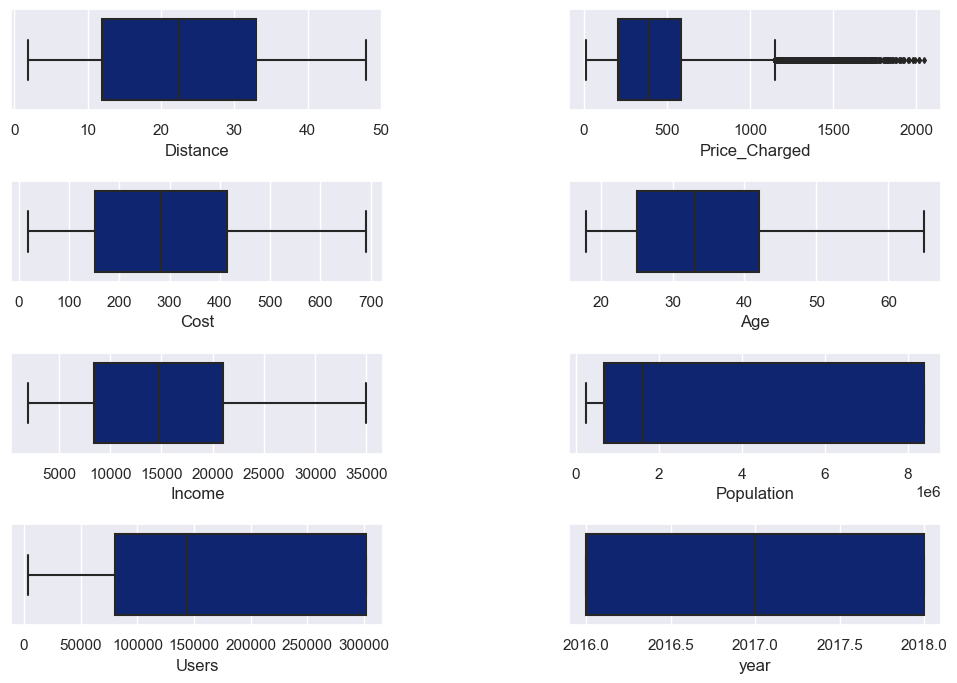

In [18]:
# check outliers in all numerical columns
fig, ax = plt.subplots(4,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.5)
for variable, subplot in zip(df.select_dtypes(['float64', 'int']).columns, ax.flatten()):
    sns.boxplot(df[variable], ax=subplot, fliersize=3)
plt.show()

**Observation**: There are outliers in the price columns. However, for the analysis, the data points won't be removed because there are actually factors that can make a cab or taxi fare vary from the normal price such as: 
1. Time of the trip as Taxi fares tends to be higher at Night and Mid-night

2. The Duration of the Trip: Though we know the distance of the trip but the time taken to complete the trip was not given and it is a general knowledge that the time taken to complete a trip constitute to the price, there may be delays like Trafiic or customer-induced delay that might have increase the duration fo the trip thereby, increasing the price.

In [19]:
## Insering a Profit column
df['Profit'] = df.Price_Charged - df.Cost
df.head(1)

Transaction_ID       Date   Company        City  Distance  Price_Charged  \
0       10000011 2016-01-08  Pink Cab  ATLANTA GA     30.45         370.95   

      Cost Customer_ID Payment_Mode Gender  Age  Income  Population  Users  \
0  313.635       29290         Card   Male   28   10813      814885  24701   

   year    month  day  Profit  
0  2016  January    8  57.315

### EXPLORATORY DATA ANALYSIS

In [151]:
customers

Company
Pink Cab      32330
Yellow Cab    39896
Name: Customer_ID, dtype: int64

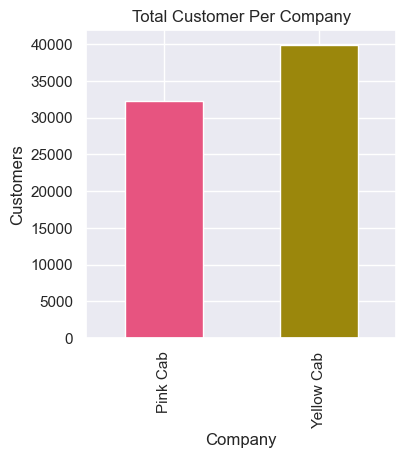

In [149]:
# Getting the unique customer count per Company
customers = df.groupby('Company').Customer_ID.nunique()

colors = ['#E75480', '#9B870C']
fig, ax = plt.subplots(figsize=(4, 4))
customers.plot(kind = 'bar', ax = ax, color = colors)
plt.title('Total Customer Per Company')
plt.xlabel('Company')
plt.ylabel('Customers')
plt.show()

**Observation:** The chart above provides an overview of the number of customers per company, specifically comparing the Yellow Cab and the Pink Cab. It is evident that the Yellow Cab has serviced over 7,000 more customers than the Pink Cab.

**Explanation:** Considering the total number of customers in the dataset is 49,171, it is worth noting that the figures in the chart indicate that there are customers who have used both the Yellow Cab and the Pink Cab. This overlap suggests that some customers have opted for both companies for their transportation needs.

The higher number of customers for the Yellow Cab can be attributed to several factors. Firstly, better brand recognition may have played a role, as the Yellow Cab may have established a stronger presence and reputation in the market compared to the Pink Cab. This could be a result of effective marketing strategies, greater visibility, or a longer history of operations.

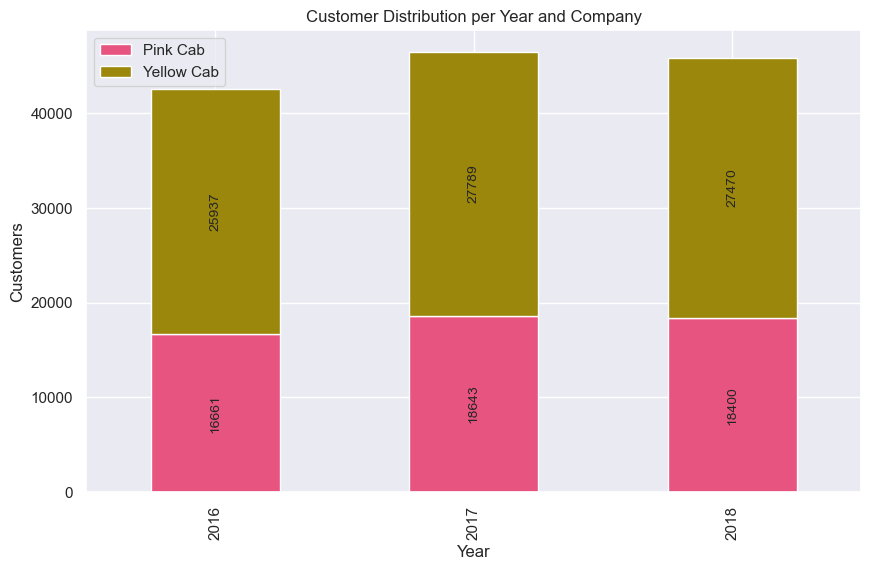

In [153]:
#Getting Customer Count by Company and Year 
cust_yr_dist = df.groupby(['year', 'Company']).Customer_ID.nunique().unstack()

fig, ax = plt.subplots(figsize=(10, 6))

cust_yr_dist.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding rounded data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, rotation=90)
    

# Adding axis title
ax.set_xlabel('Year')
ax.set_ylabel('Customers')
ax.set_title('Customer Distribution per Year and Company')
ax.legend(label)
    
plt.show()

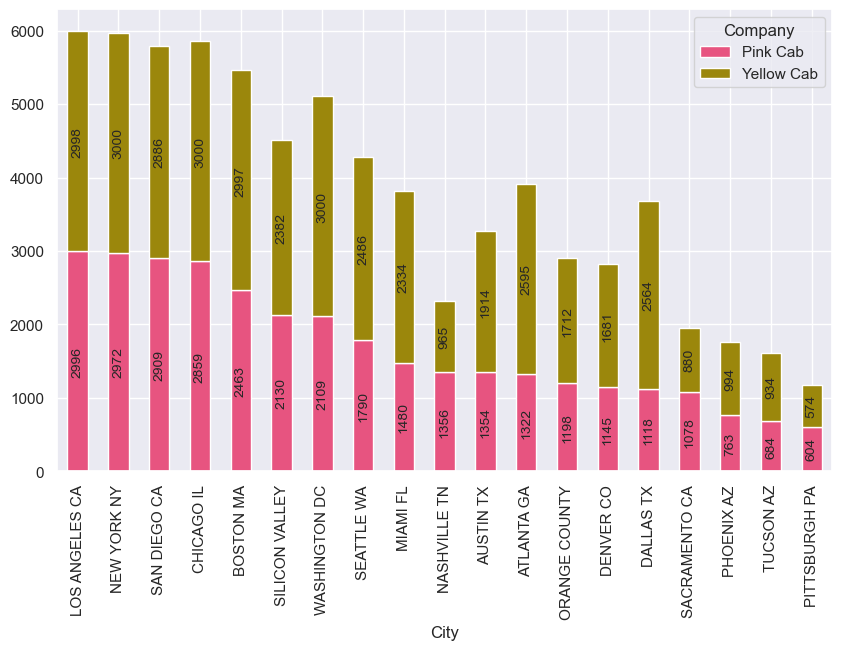

In [154]:
#grouping-by 
df_customer_dist = df.groupby(['City', 'Company'])['Customer_ID'].nunique().unstack().\
sort_values(by = 'Pink Cab', ascending = False)

fig, ax = plt.subplots(figsize=(10, 6))

df_customer_dist.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding rounded data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, rotation=90)
    
plt.show()

**Observation:** The chart presented above illustrates the distribution of customers among the cab companies across various cities. A comprehensive analysis reveals that there is a relatively equal distribution of customers between the Pink Cab and Yellow Cab in cities such as **Los Angeles, New York, San Diego, and Chicago.** However, certain cities exhibit contrasting customer preferences.

In cities like **Atlanta, Washington DC, Seattle WA, and Dallas TX,** the Yellow Cab appears to have a larger customer base, indicating its popularity and wider reach in these metropolitan areas. Conversely, the Pink Cab demonstrates a stronger presence in cities like **Nashville, Sacramento, and Pittsburgh**.

The contrasting customer distribution between the two companies may reflect factors such as brand reputation, service quality, marketing strategies, or pricing. Additionally, the observation suggests that the Yellow Cab tends to attract a significant customer base in sophisticated and affluent cities, potentially due to its established presence and ability to cater to the preferences of a more discerning clientele.

This analysis provides valuable insights into the customer distribution across cities for both cab companies, highlighting the diverse market dynamics and customer preferences within the transportation industry.


## Ride and Profit Analysis

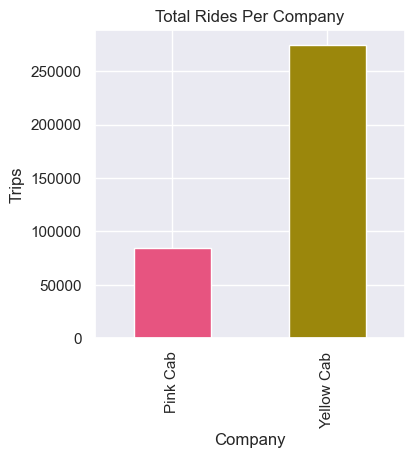

In [155]:
#Total User per company.
users = df.groupby('Company').Users.count()
fig, ax = plt.subplots(figsize=(4, 4))
users.plot(kind = 'bar', ax = ax, color = colors)
plt.title('Total Rides Per Company')
plt.xlabel('Company')
plt.ylabel('Trips')
plt.show()

**Observation**: From the above, it can be seen there is a wide ratio of 4:1 in terms of the rides completed by the Yellow cab company as compared to the Pink cab. The Yellow cab has completed over 250,000 rides while the Pink Cab has completed over 75,000 rides for the period considered. The huge difference between the number of rides for each company might be that the Yellow company has more Taxis/Cabs in operation than the Pink taxi or that the customer get more satisfied service with the Yellow company as against the Pink. However, this is difficult to establish since there is not information as to the number of Cabs/Taxis in Operation/Company. Further Explaration might give information to the customer satisfaction or distribution per company.

#### Ride Distribution by Gender

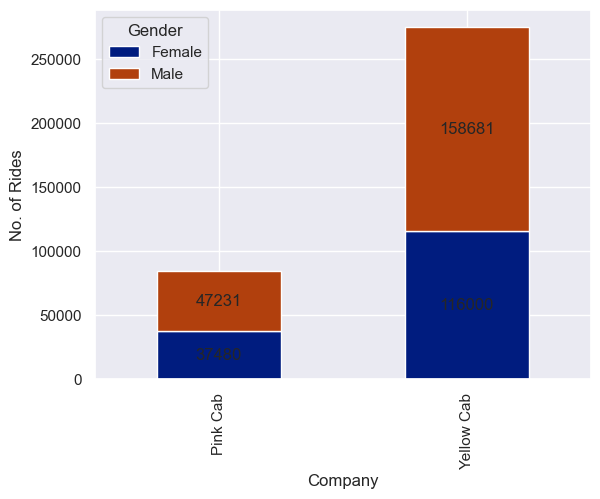

In [130]:
gender = df.groupby(['Company', 'Gender']).Users.count().unstack().reset_index().set_index('Company')

ax = gender.plot(kind='bar', stacked=True)


# Adding data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')
    
ax.set_xlabel('Company')
ax.set_ylabel('No. of Rides')

plt.show()

**Observation**: As shown in the chart, Male customers has completed more rides as compared to females for both cab companies. 

#### Daily Average Ride per Company

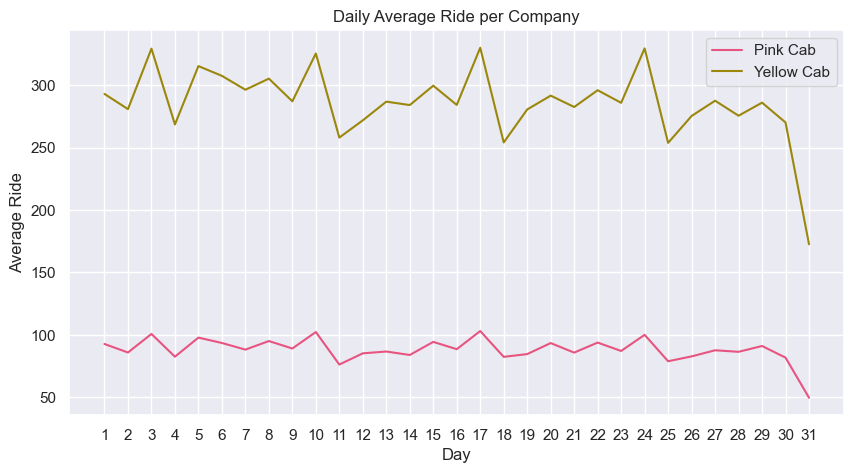

In [156]:
ride_dist_day = df.groupby(['day', 'Company']).agg(avg_profit=('Customer_ID', lambda x: round(x.count() / 31, 2))).unstack()

colors = ['#E75480', '#9B870C']
label = ['Pink Cab', 'Yellow Cab']

fig, ax = plt.subplots(figsize=(10, 5))

ride_dist_day.plot(kind='line', color=colors, ax=ax)

ax.set_xlabel('Day')
ax.set_ylabel('Average Ride')
ax.set_title('Daily Average Ride per Company')
ax.legend(label)

# Setting the x-axis ticks to show all days
ax.set_xticks(ride_dist_day.index)

plt.show()

**Observation**: The chart above illustrate the Daily average rides per Company, it emphasizes the importance of monitoring and understanding daily ride patterns to make data-driven business decisions, enhance operational efficiency, and capitalize on customer demand trends. 

A similar trend is observed for both companies, The number of rides tends to peak on the 3rd day of each month, followed by a period of irregular fluctuations over the next 6 days. This irregular pattern continues until the 10th day when another peak in ride volume is observed. Subsequently, the number of rides fluctuates irregularly for the next 6 days, followed by another peak on the 17th day. This pattern repeats throughout the month, with peaks occurring every 7 days (i.e., 3rd, 10th, 17th, 24th, and so on).

The irregular fluctuations in ride volume between the peak days suggest variations in customer demand and usage patterns. further investigation will be done to analyze the factors that contribute to these fluctuations, particularly the peak days such as day of the week, promotional offers, events, holidays, or other external factors that may influence customer behavior.

Furthermore, it is evident that the Yellow Cab consistently experiences higher ride volumes compared to the Pink Cab. The Yellow Cab averages nearly 200 rides on the lowest days, while the Pink Cab only achieves around 50 rides. On the highest days, the Yellow Cab reaches over 300 rides, while the Pink Cab records around 100 rides. This significant difference in ride volume indicates the Yellow Cab's stronger market presence, retention and customer preference.

Considering the 7-day cyclic pattern mentioned in the second observation, where peaks in ride volume occur every 7 days (3rd, 10th, 17th, 24th, and so on), it is plausible that the higher number of rides on Fridays contributes to these peaks.

The observed ride patterns provide insights into the demand dynamics within the cab industry, highlighting the Yellow Cab's ability to attract and retain customers more effectively than the Pink Cab. Understanding these patterns can assist in optimizing resource allocation, scheduling, and marketing strategies to maximize profitability and customer satisfaction.

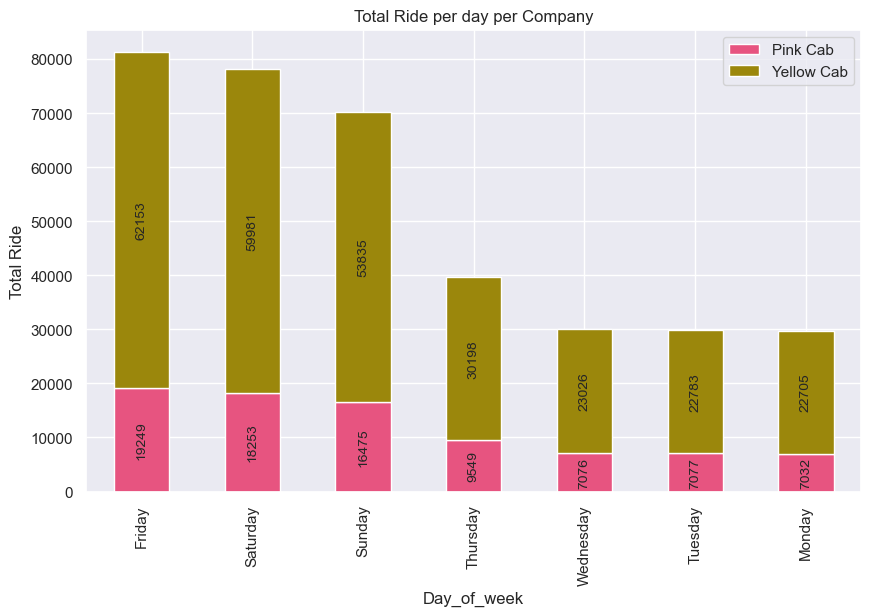

In [160]:
day_ride = df.groupby(['day_of_week', 'Company']).Customer_ID.count().unstack().sort_values(by = 'Yellow Cab',
                                                                                            ascending = False)

fig, ax = plt.subplots(figsize=(10, 6))

day_ride.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding rounded data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, rotation=90)
    
    
ax.set_xlabel('Day_of_week')
ax.set_ylabel('Total Ride')
ax.set_title('Total Ride per day per Company')
ax.legend(label)

plt.show()

**Observation**: The chart presents the distribution of rides by the day of the week for both Yellow Cab and the Pink Cab. It is evident that the number of rides peaks on Fridays and weekends, with each peak day recording over 70,000 rides. On the other hand, the rides on other days of the week remain relatively lower, averaging below 40,000 rides per day.

When analyzing the performance of each cab company in terms of the number of rides generated on different days of the week, the Yellow Cab consistently outperforms the Pink Cab. This indicates that the Yellow Cab has been more successful in attracting customers and capturing a larger market share, regardless of the day of the week.

The higher number of rides on Fridays and weekends can be attributed to several factors. These days typically coincide with the end of the workweek and the start of the weekend, when individuals are more likely to engage in social activities, leisure outings, and recreational events. Consequently, the demand for transportation services increases, leading to a higher number of rides for both cab companies.

The dominance of the Yellow Cab in terms of ride volume across all days of the week suggests that the company has implemented effective marketing strategies, provided reliable service, and maintained customer satisfaction, resulting in a larger customer base and higher demand for their services. This could be attributed to factors such as competitive pricing, efficient operations, customer loyalty programs, and effective brand positioning.

Considering the 7-day cyclic pattern mentioned in the earlier chart, where peaks in ride volume occur every 7 days (3rd, 10th, 17th, 24th, and so on), it is plausible that the higher number of rides on Fridays contributes to these peaks.

Overall, the observation highlights the importance of understanding customer behavior and demand patterns based on the day of the week. By aligning their operations and marketing efforts to cater to these patterns, cab companies can optimize their resources, enhance customer experience, and drive business growth.

*To capitalize on these insights, the Pink Cab company may consider studying the strategies and practices of the Yellow Cab to identify areas for improvement and enhance their competitive position in the market. By analyzing customer preferences, identifying potential gaps in service offerings, and focusing on customer satisfaction, the Pink Cab can aim to increase its market share and improve its performance across all days of the week.*

In [25]:
df.groupby(['Company']).agg(
    Total_Profit=('Profit', 'sum'),
    Total_ride=('Users', 'count'),
    avg=('Profit', lambda x: round(x.sum() / x.count(), 2))
).reset_index()

Company  Total_Profit  Total_ride     avg
0    Pink Cab  5.307328e+06       84711   62.65
1  Yellow Cab  4.402037e+07      274681  160.26

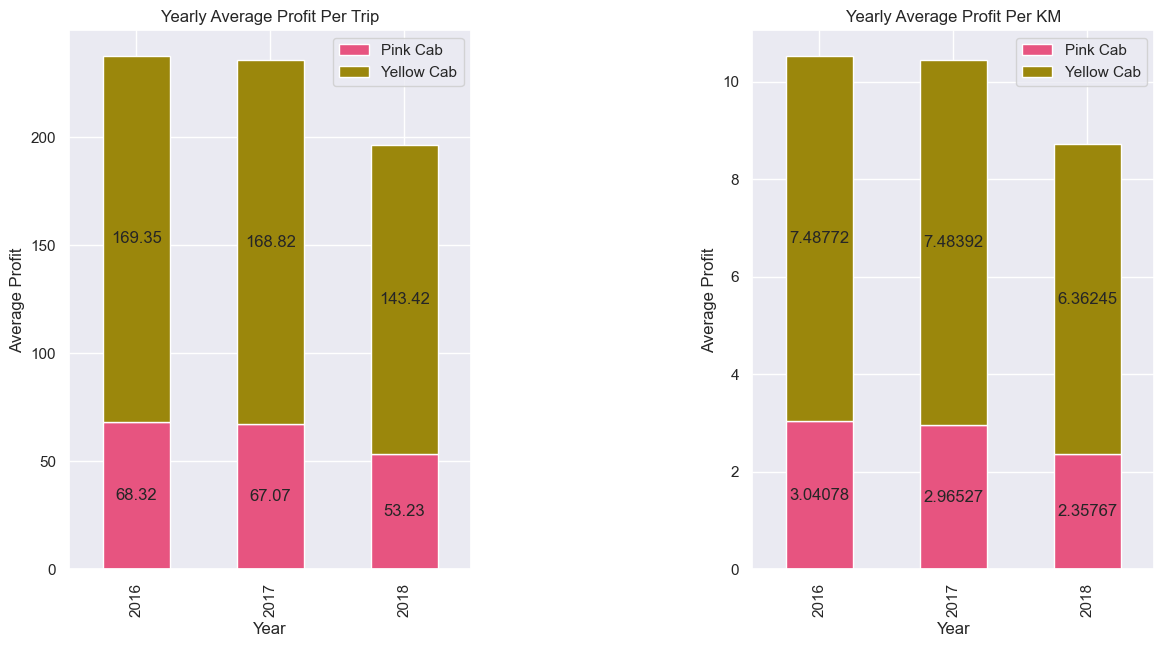

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

#calculating the average profit per trip
avg_profit = df.groupby(['year', 'Company']).agg(avg_profit=('Profit', lambda x: round(x.sum() / x.count(), 2))).unstack()

colors = ['#E75480', '#9B870C']
label = ['Pink Cab', 'Yellow Cab']

avg_profit.plot(kind='bar', stacked=True, color=colors, ax = ax1)

# Adding data labels on the bars
for container in ax1.containers:
    ax1.bar_label(container, label_type='center')
    
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Profit')
ax1.set_title('Yearly Average Profit Per Trip')
ax1.legend(label)

# average profit per km travelled
result = df.groupby(['year', 'Company']).agg(total_profit=('Profit', 'sum'),total_distance=('Distance', 'sum'))
result['avg_profit_per_km'] = result['total_profit'] / result['total_distance']
result = result['avg_profit_per_km'].unstack()

colors = ['#E75480', '#9B870C']
label = ['Pink Cab', 'Yellow Cab']

result.plot(kind='bar', stacked=True, color=colors, ax = ax2)

# Adding data labels on the bars
for container in ax2.containers:
    ax2.bar_label(container, label_type='center')

ax2.set_xlabel('Year')
ax2.set_ylabel('Average Profit')
ax2.set_title('Yearly Average Profit Per KM')
ax2.legend(label)

plt.subplots_adjust(wspace=0.7)

plt.show()

**Observation**:
As shown in the charts above, chart 1 shows the Yearly average profit per company and Chart 2 shows the average profit generated by each Company per Km covered, an the average, yellow company is generating double the profit of pink company on each trip and each KM covered/travelled. This might be due to the higher number of trips covered by the Yellow company. However, since the average was used, it can be inferred that Yellow company are generating more profit than the Pink compay. This might be due to a higher demanad, larger customer base and efficient operational cost management by the Yellow Company

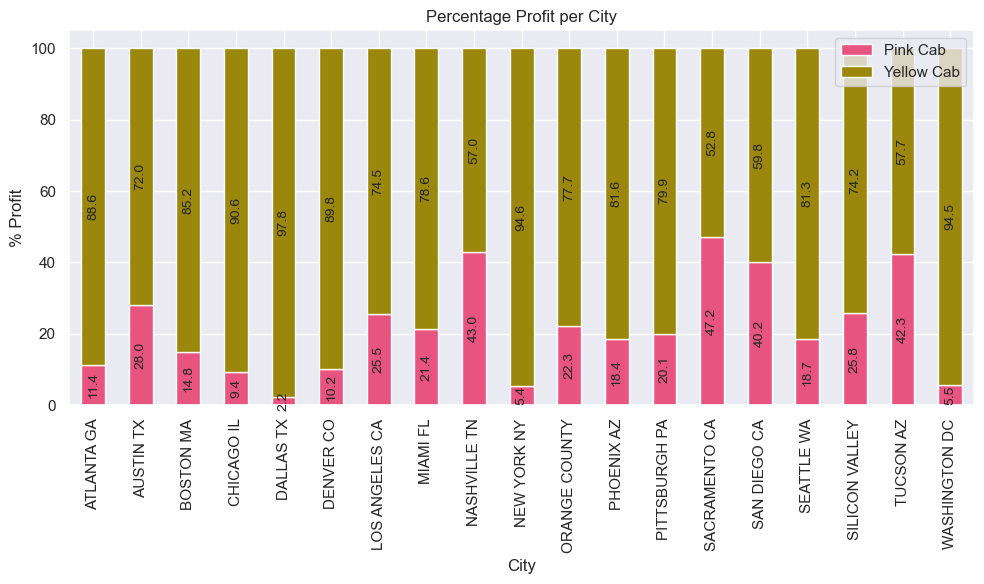

In [27]:
# Group by city and company, and calculate the total profit per city and company
df_grouped = df.groupby(['City', 'Company'])['Profit'].sum()

# Calculate the percentage of total profit for each company within each city
df_percentage = df_grouped / df_grouped.groupby(level='City').transform('sum') * 100
df_percentage = df_percentage.unstack()

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#E75480', '#9B870C']
label = ['Pink Cab', 'Yellow Cab']

df_percentage.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Adding rounded data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, fmt='%.1f', rotation=90)

ax.set_xlabel('City')
ax.set_ylabel('% Profit')
ax.set_title('Percentage Profit per City')
ax.legend(label)

plt.tight_layout()
plt.show()


**Observation**:

The chart above displays the percentage profit generated by each cab company in different cities, this chart provides valuable insights into their market presence and profitability across various locations.

It is evident that the Yellow Cab company outperforms the Pink Cab company in terms of profit generation in all cities. This suggests that the Yellow Cab company has a stronger market presence and customer base compared to the Pink Cab company. The higher profitability of the Yellow Cab company can be attributed to factors such as brand recognition, customer loyalty, and effective marketing strategies.

The varying percentages of profit in different cities indicate the level of market penetration and popularity of each cab company in specific locations. In cities like: **Boston, New York, Washington DC, Atlanta, Denver, Chicago,** the Yellow Cab company generates a significantly higher percentage of profit compared to the Pink Cab company. This suggests that the Yellow Cab company has established a strong foothold in those cities, possibly due to factors like a larger fleet, better service quality, or competitive pricing.

However, In cities like **Nashville, Sacramento, San Diego, Tucson AZ,** although the Yellow Cab company still generates a higher percentage of profit, the difference between the two companies is relatively smaller. This could imply that the market competition is more intense

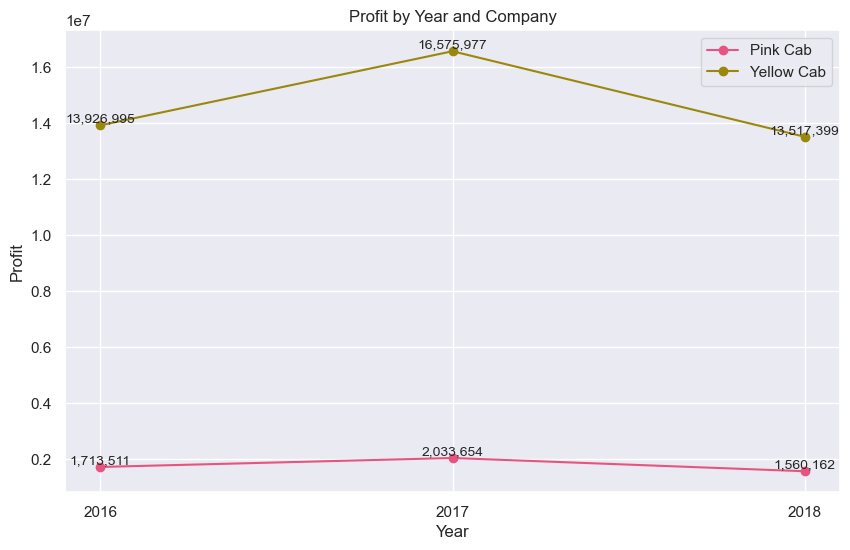

In [131]:
# Set the locale to use comma separators for thousands
locale.setlocale(locale.LC_ALL, '')

colors = ['#E75480', '#9B870C']
label = ['Pink Cab', 'Yellow Cab']

df_profit = df.groupby(['year', 'Company'])['Profit'].sum().unstack()

fig, ax = plt.subplots(figsize=(10, 6))

for company, color in zip(df_profit.columns, colors):
    ax.plot(df_profit.index, df_profit[company], marker='o', color=color, label=company)

# Adding data labels for each year and company
for company in df_profit.columns:
    for year, profit in zip(df_profit.index, df_profit[company]):
        x_pos = year
        y_pos = profit
        # Format the profit with comma separators
        formatted_profit = locale.format_string("%d", y_pos, grouping=True)
        ax.text(x_pos, y_pos, f'{formatted_profit}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Year')
ax.set_ylabel('Profit')
ax.set_title('Profit by Year and Company')
ax.legend(label)

# Set the x-axis ticks to display only the years
ax.set_xticks(df_profit.index)

plt.show()


**Observation:** The chart above illustrates the yearly profit generated by each cab company. Both the Yellow Cab and the Pink Cab experienced a similar trend in terms of profit generation over the years.

From 2016 to 2017, there was an increase in profit for both companies. However, from 2017 to 2018, there was a noticeable decline in profit for both companies. This indicates that there may have been external factors or changes in the market that affected the profitability of the cab industry during that period.

It is important to note that the Yellow Cab consistently outperformed the Pink Cab in terms of profit generation throughout the years studied. The Yellow Cab generated profits that were at least seven times higher than those generated by the Pink Cab for each year. This suggests that the Yellow Cab had a stronger market presence, higher customer demand, or more efficient business operations compared to the Pink Cab.

#### Profit by Income Classification

In [38]:
incomebin = [0,5000,20000,40000]
incomeclass = ['Low', 'Middle', 'High']
df['IncomeClass'] = pd.cut(df.Income, incomebin, right = False, labels = incomeclass)

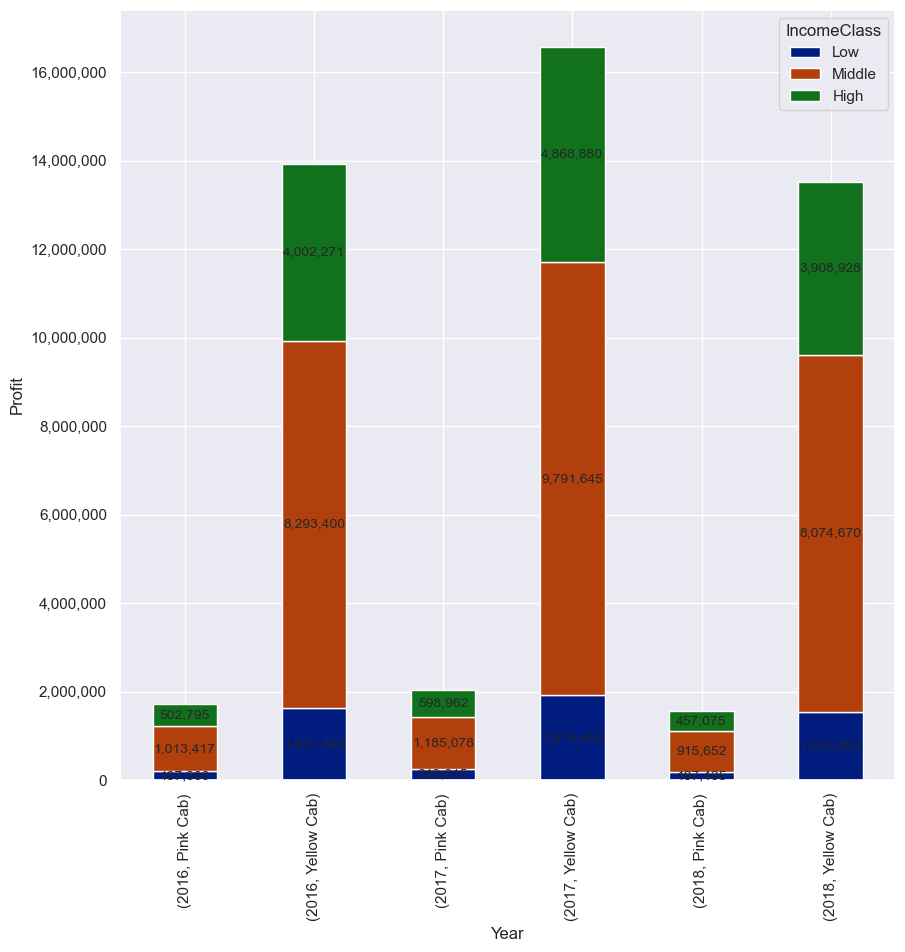

In [140]:
df_income = df.groupby(['year', 'Company', 'IncomeClass']).Profit.sum().unstack()

fig, ax = plt.subplots(figsize=(10, 10))

df_income.plot(kind='bar', stacked=True, ax=ax)

# Adding rounded data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, 
                 labels=[f"{val:,.0f}" for val in container.datavalues])

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Year, Company')
ax.set_ylabel('Profit')

# Format y-axis tick labels
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


**Observation:** The chart provides insights into the income classification of customers and their contribution to the profit generated by each cab company. It is evident that the Middle and High-income classes play a significant role in generating profit for both the Yellow Cab and the Pink Cab.

Specifically, the Middle and High-income classes contribute the most to the profit generated by each company. This suggests that customers belonging to these income classes are more likely to utilize cab services and generate higher revenue for the companies.

Furthermore, when comparing the profit generated by each income class, the Yellow Cab outperforms the Pink Cab across all income classes. This indicates that the Yellow Cab company is more successful in attracting and serving customers from various income segments, resulting in higher profitability.

The observed trend highlights the importance of targeting and catering to customers from the Middle and High-income classes for maximizing profit in the cab industry. By focusing on providing quality services and meeting the preferences and expectations of these customer segments, cab companies can enhance their profitability and overall performance.

Understanding the income classification and its relationship with profit contribution allows cab companies to refine their business strategies, allocate resources effectively, and tailor their services to different customer segments. By continuously monitoring and analyzing these patterns, companies can make informed decisions to drive sustainable growth and profitability.

#### Profit by Age classification

In [42]:
agebin = [18,25,55,70]
ageclass = ['YoungAdult', 'Adult', 'Elder']
df['AgeClass'] = pd.cut(df.Age, agebin, right = False, labels = ageclass)

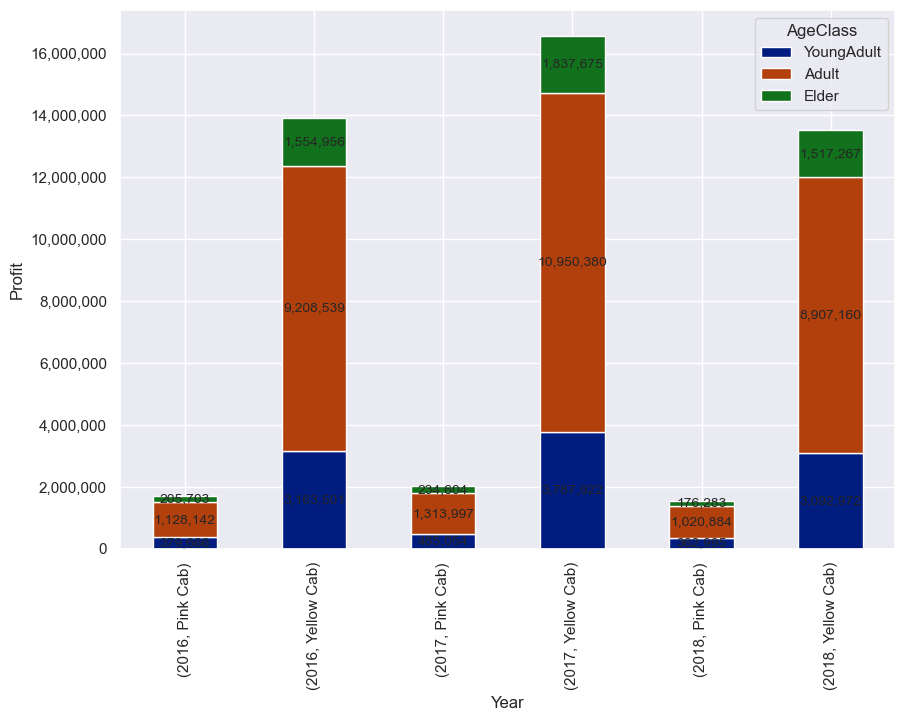

In [43]:
import matplotlib.ticker as ticker

df_age = df.groupby(['year', 'Company', 'AgeClass']).Profit.sum().unstack()

fig, ax = plt.subplots(figsize=(10, 7))

df_age.plot(kind='bar', stacked=True, ax=ax)

# Adding rounded data labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, 
                 labels=[f"{val:,.0f}" for val in container.datavalues])

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Year')
ax.set_ylabel('Profit')

# Format y-axis tick labels
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()

**Observation:** The chart above provides insights into the age classification of customers and their contribution to the overall profit generated by the cab industry. It is evident that the Adult age group (25-55) contributes the most to the profit of both the Yellow Cab and the Pink Cab, followed by the Young Adult age group (18-25).

The Adult age group, representing individuals in their prime working years, emerges as the primary source of profit for the cab industry. This can be attributed to several factors, such as a higher likelihood of needing transportation services for commuting to work, business meetings, or other professional engagements. Additionally, adults in this age range are more likely to have a higher disposable income, allowing them to utilize cab services more frequently.

Furthermore, the Young Adult age group also contributes significantly to the profit of the cab industry. This age group, typically comprising college students and young professionals, may utilize cab services for various purposes, including social activities, leisure outings, and transportation to educational institutions.

When comparing the profit generated by each age group, it is evident that the Yellow Cab outperforms the Pink Cab across all age brackets. This suggests that the Yellow Cab company has been successful in attracting a wider range of customers and capturing a larger share of the market, resulting in higher profitability.

The observed trend highlights the importance of targeting and serving customers across different age groups to maximize profit in the cab industry. By understanding the preferences, needs, and behaviors of customers within each age bracket, cab companies can tailor their services and marketing strategies to effectively cater to their diverse customer base.

Moreover, the higher profit generation by the Yellow Cab emphasizes the need for competitive pricing, quality service offerings, and effective customer engagement to attract and retain customers across all age groups.

By leveraging these insights, cab companies can make informed decisions regarding pricing strategies, service enhancements, and targeted marketing efforts, ultimately driving profitability and sustained success in the industry.

#### Customer retention

In [120]:
dfret = df.groupby(['year','Company', 'Customer_ID']).Users.count().to_frame().reset_index()
dfret5 = dfret[dfret.Users >= 5]
repeating_customers = dfret5.groupby(['year','Company']).Users.count().unstack()

# Calculate customer retention rate
retention_rate = (repeating_customers / total_customers) * 100

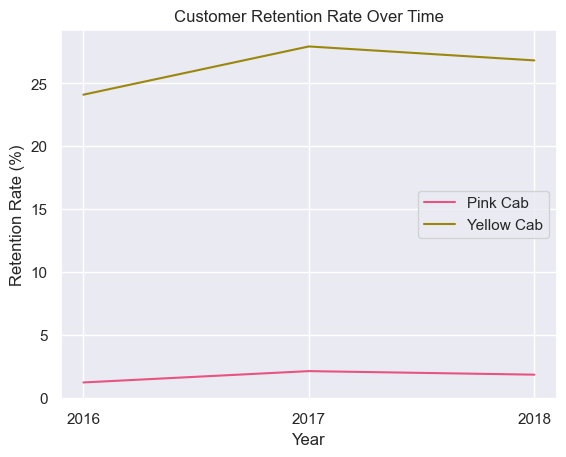

In [351]:
# Convert the years to integers
years = retention_rate.index.astype(int)

colors = ['#E75480', '#9B870C']
labels = ['Pink Cab', 'Yellow Cab']

# Plotting the line chart
for i, label in enumerate(labels):
    plt.plot(years, retention_rate[label], label=label, color=colors[i])

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Retention Rate (%)')
plt.title('Customer Retention Rate Over Time')

# Adding gridlines
plt.grid(True)

# Formatting the x-axis tick labels
plt.xticks(years)  # Set the x-axis tick positions
plt.gca().xaxis.set_major_formatter('{:.0f}'.format)  # Format the tick labels as integers

# Adding legend
plt.legend()

# Show the plot
plt.show()


**Observation**: The chart above presents the customer retention rates for both the Yellow Cab and the Pink Cab companies. The retention rates are calculated based on the number of rides taken by customers. In this analysis, customers who have taken 5 or more rides with a company are classified as repeating customers.

It can be observed from the chart that the Yellow Cab company has a customer retention rate of approximately 25% for each year studied. This means that around 25% of the customers who have taken 5 or more rides with the Yellow Cab continue to use their services over time.

This high customer retention rate suggests that the Yellow Cab company has been successful in delivering a satisfactory customer experience and providing personalized services that meet the needs and expectations of their customers. It indicates that customers are satisfied with the quality of service, reliability, and convenience offered by the Yellow Cab, leading them to choose the company for their transportation needs repeatedly.

On the other hand, the customer retention rate for the Pink Cab is not mentioned in the observation. Without this information, it is difficult to make a direct comparison between the two companies in terms of customer retention. Further analysis or additional data would be needed to assess the customer retention rate of the Pink Cab and make a comprehensive comparison between the two companies.

Overall, the high customer retention rate of the Yellow Cab suggests that they have been successful in building customer loyalty and maintaining a strong customer base.

## RECOMMENDATION

Both Cab companies has been analyzed and rated based on 5 key Business parameters. Below are the recommendations that can be drawn from the insights to help XYZ with their investment decision:

**1. Customer Distribution:** The customer distribution analysis shows that both the Yellow Cab and the Pink Cab have a relatively equal distribution of customers in cities like Los Angeles, New York, San Diego, and Chicago. However, Yellow Cab has more customer in more expensive and sophistocated areas of the United States.


**2. Ride Volume:** The Yellow Cab consistently outperforms the Pink Cab in terms of ride volumes, with a significant difference in the number of rides completed. This indicates a stronger market presence, customer satisfaction, and preference for the Yellow Cab. This shows the Yellow Cab's fleet size, service quality, and customer loyalty.


**3. Day-wise Performance:** The Yellow Cab consistently outperforms the Pink Cab in terms of the number of rides generated on different days of the week. This suggests that the Yellow Cab has been more successful in attracting customers and capturing a larger market share, regardless of the day.


**4. Profitability:** The Yellow Cab generates higher profits compared to the Pink Cab in various aspects, including yearly average profit, profit per kilometer covered, and profit across different cities and income brackets. This indicates a stronger market presence, larger customer base, and potentially more efficient operational cost management by the Yellow Cab. 

**5. Customer Retention:** The Yellow Cab has a customer retention rate of approximately 25% for customers who have taken 5 or more rides. This suggests a level of customer satisfaction and loyalty towards the Yellow Cab's services. 


Based on these findings, it is recommended that XYZ considers investing in the Yellow Cab company. The Yellow Cab demonstrates a stronger market presence, higher ride volumes, better profitability, and a good level of customer retention.

### RECOMMENDATIONS FOR PINK CAB

Based on the findings, here are some recommendations for the Pink Cab to enhance its market performance and compete with the Yellow Cab:

1. Improve Brand Recognition: Invest in marketing strategies to enhance the Pink Cab's brand recognition and increase awareness among potential customers. This can include targeted advertising campaigns, social media presence, and partnerships with relevant local businesses or events.

2. Competitive Pricing: Conduct a pricing analysis to ensure that the Pink Cab's fares are competitive and attractive to customers. Consider offering competitive promotions, loyalty programs, or discounted fares during off-peak hours to incentivize ridership.

3. Technology Integration: Embrace technology to streamline operations and enhance the customer experience. Implement features such as a user-friendly mobile app for booking rides, real-time tracking, cashless payment options, and integration with popular ride-hailing platforms.

4. Focus on Customer Feedback: Establish a feedback system to actively listen to customer concerns, suggestions, and complaints. Regularly analyze and address feedback to identify areas for improvement and make necessary adjustments to meet customer expectations.

5. Collaborate with Local Businesses: Form partnerships with local businesses, hotels, airports, or event organizers to increase visibility and attract customers. Offer exclusive deals or packages in collaboration with these partners to provide added value to customers.

By implementing these recommendations, the Pink Cab can enhance its market performance, attract more customers, and compete effectively with the Yellow Cab. It is crucial for the Pink Cab to adapt to evolving customer preferences, improve service quality, and differentiate itself in terms of brand image, pricing, and technology integration.

### Rides forecasting for the Yellow cab company

In [226]:
#slicing out only the Yellow cab data for prediction of the ride.
df_yel = df[df.Company == 'Yellow Cab']
df_yel['Months'] = df['Date'].dt.strftime('%Y-%m-01')

In [239]:
data = df_yel.groupby('Months').agg(Rides = ('Users','count'))

In [324]:
# Split the data into training and test sets
train_data = data[data.index < '2019-01-01']
test_data = data[(data.index >= '2016-01-01')]

In [ ]:
#slicing out only the Yellow cab data for prediction of the ride.
df_yel = df[df.Company == 'Yellow Cab']
df_yel['Months'] = df['Date'].dt.strftime('%Y-%m-01')

data = df_yel.groupby('Months').agg(Rides = ('Users','count'))

#inputing the date as from 2019-01-01 till 2019-12-01 into the test data
missing_dates = pd.date_range(start='2019-01-01', periods = 12, freq='MS')
missing_dates = pd.DataFrame(index=missing_dates)

# Append the missing dates to the test data index
test_data = pd.concat([test_data, missing_dates])

test_data.index = pd.to_datetime(test_data.index)

# Convert the index to a string representation with the desired format
test_data.index = test_data.index.strftime('%Y-%m-%d')

# Use pmdarima to automatically determine the optimal p, d, and q values
model = pm.auto_arima(train_data['Rides'], seasonal=True, m=12, trace = True)

order = model.order
seasonal_order = model.seasonal_order

# Create the SARIMAX model
sarimax_model = SARIMAX(train_data['Rides'], order=order, seasonal_order=seasonal_order)

#fit the sarimax mode
result = sarimax_model.fit()

#making predictions with the SARIMAX

predictions = result.predict(start='2016-01-01', end='2019-11-30')
predictions = predictions.round().astype('int')
predictions

#appending the predictions to the test_data
test_data['Pred'] = predictions

test_data[['Rides', 'Pred']].plot()

In [325]:
#inputing the date as from 2019-01-01 till 2019-12-01 into the test data
missing_dates = pd.date_range(start='2019-01-01', periods = 12, freq='MS')
missing_dates = pd.DataFrame(index=missing_dates)

# Append the missing dates to the test data index
test_data = pd.concat([test_data, missing_dates])

test_data.index = pd.to_datetime(test_data.index)

# Convert the index to a string representation with the desired format
test_data.index = test_data.index.strftime('%Y-%m-%d')

### p,q,d.

To determine the optimal values for p (autoregression), q (moving average), and d (integration) in the ARIMA model, I will utilize the pmdarima library. pmdarima, also known as "Pyramid Auto ARIMA," is a Python library specifically designed to automatically identify the most suitable ARIMA models for time series analysis and forecasting tasks. By leveraging pmdarima, users can seamlessly and efficiently select the appropriate p, q, and d values required for ARIMA modeling. This library offers a user-friendly interface and simplifies the process of identifying optimal ARIMA models, making it a valuable tool for time series analysts and forecasters.

In [288]:
# Use pmdarima to automatically determine the optimal p, d, and q values
model = pm.auto_arima(train_data['Rides'], seasonal=True, m=12, trace = True)

order = model.order
seasonal_order = model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.317, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=375.899, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=374.662, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=376.476, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=375.827, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=372.690, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=374.165, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=374.744, Time=0.09

In [330]:
# Create the SARIMAX model
sarimax_model = SARIMAX(train_data['Rides'], order=order, seasonal_order=seasonal_order)

#fit the sarimax mode
result = sarimax_model.fit()

To perform the forecast, I will be using the SARIMAX model as it incorporatse seasonality patterns and allows for the inclusion of exogenous variables. SARIMAX is short for Seasonal AutoRegressive Integrated Moving Average with eXogenous variables, is a statistical model used for time series forecasting. It is an extension of the ARIMA (AutoRegressive Integrated Moving Average) model.

In [326]:
#making predictions with the SARIMAX

predictions = result.predict(start='2016-01-01', end='2019-11-30')
predictions = predictions.round().astype('int')
predictions

#appending the predictions to the test_data
test_data['Pred'] = predictions

In [327]:
test_data

Rides   Pred
2016-01-01   3719.0      0
2016-02-01   4674.0   3719
2016-03-01   5146.0   4674
2016-04-01   5360.0   5146
2016-05-01   5967.0   5360
2016-06-01   5667.0   5967
2016-07-01   6814.0   5667
2016-08-01   6918.0   6814
2016-09-01   8130.0   6918
2016-10-01   9697.0   8130
2016-11-01   9320.0   9697
2016-12-01  10827.0   9320
2017-01-01   6454.0  13474
2017-02-01   5358.0   7572
2017-03-01   6219.0   5911
2017-04-01   6372.0   6470
2017-05-01   6531.0   7083
2017-06-01   6613.0   6180
2017-07-01   7438.0   7956
2017-08-01   8439.0   7560
2017-09-01   9922.0   9858
2017-10-01  10852.0  11757
2017-11-01  11145.0  10411
2017-12-01  12846.0  12910
2018-01-01   7944.0   7083
2018-02-01   4900.0   5686
2018-03-01   6058.0   5923
2018-04-01   5619.0   6160
2018-05-01   6243.0   5488
2018-06-01   6556.0   6552
2018-07-01   6834.0   7109
2018-08-01   8227.0   8296
2018-09-01   9149.0   9743
2018-10-01   9727.0   9604
2018-11-01  11230.0  10405
2018-12-01  11766.0  12898
2019-01-01      NaN   7322
2019-02-01      NaN   3772
2019-03-01      NaN   5017
2019-04-01      NaN   4229
2019-05-01      NaN   5340
2019-06-01      NaN   5655
2019-07-01      NaN   5756
2019-08-01      NaN   7104
2019-09-01      NaN   7643
2019-10-01      NaN   8300
2019-11-01      NaN  10334
2019-12-01      NaN  10141

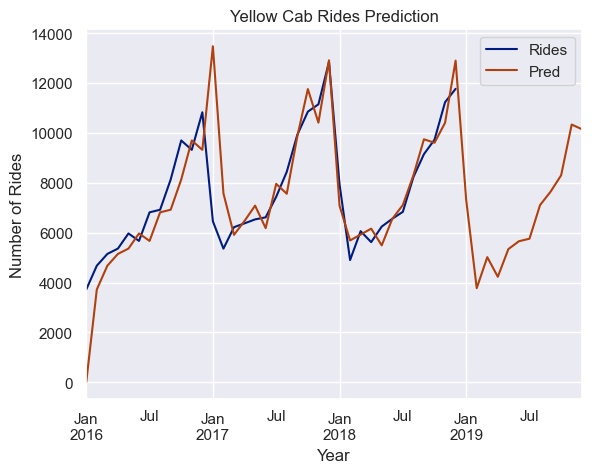

In [339]:
test_data[['Rides', 'Pred']].plot()


# Modify x-axis tick labels
tick_labels = test_data.index.strftime('%Y-%m')  # Format to display only year and month
ax.set_xticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels, rotation=45)

# Customize the plot
plt.title('Yellow Cab Rides Prediction')
plt.xlabel('Year')
plt.ylabel('Number of Rides')


# Show the plot
plt.show()

### Model Evaluation

In [343]:
## Model Evaluation: 

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(test_data['Rides'] - test_data['Pred']))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((test_data['Rides'] - test_data['Pred']) ** 2))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data['Rides'] - test_data['Pred']) / test_data['Rides'])) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)



Mean Absolute Error (MAE): 890.8333333333334
Root Mean Squared Error (RMSE): 1536.32235838996
Mean Absolute Percentage Error (MAPE): 13.942735794497263


## Explanation
**Mean Absolute Error (MAE)**: The MAE value of about 890.83 indicates the average absolute difference between the predicted and actual ride values. This means that, on average, the model's predictions deviate from the actual values by around 890.83. The MAE provides a measure of the average magnitude of the errors without considering their direction. In this case, the model's predictions have an average absolute error of 890.83. Considering that our data is based on monthly figure. That is about 29 rides deviation per day.

**Root Mean Squared Error (RMSE):** The RMSE value of approximately 1536.32 represents the square root of the average squared difference between the predicted and actual ride values. It measures the average magnitude of the prediction errors, giving more weight to larger errors. In this case, the RMSE indicates that, on average, the model's predictions deviate from the actual values by approximately 1536.32. 

**Mean Absolute Percentage Error (MAPE):** The MAPE value of approximately 13.94% indicates the average percentage difference between the predicted and actual ride values. It provides a measure of the relative magnitude of the errors compared to the actual values. In this case, the model's predictions have an average relative error of 13.94%, meaning they deviate from the actual values by approximately 13.94% on average.

Based on these metrics, it can be concluded that the model's performance is good. 

Performing the ride forecasts of the cab company can provide several important benefits, some of which:

1. The figures from these forecasts can help in planning and optimizing resources such as vehicles, drivers, and fuel. The company can allocate resources efficiently, ensuring the right number of vehicles and drivers are available at the right time and location. 

2. Forecasts enable effective revenue management strategies. By predicting future ride demand, the company can adjust pricing strategies, promotional offers, and incentives to maximize revenue

3. The forecast figures contribute to a better customer experience by understanding and predicting ride demand, the company can provide timely and efficient service to customers. This leads to reduced waiting times, improved reliability, and overall customer satisfaction.